In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Read dataset and reset index
df = pd.read_csv('predict-model-dataset.csv', sep = ',')
df.set_index('ID', inplace = True)
df.head()

,WAREHOUSE_BLOCK,MODE_OF_SHIPMENT,CUSTOMER_CARE_CALLS,CUSTOMER_RATING,COST_OF_THE_PRODUCT,PRIOR_PURCHASES,PRODUCT_IMPORTANCE,GENDER,DISCOUNT_OFFERED,WEIGHT_IN_GMS,DELIVERY_DELAYED
ID,,,,,,,,,,,
1,D,Flight,4,2,177,3,low,F,44,1233,1
2,F,Flight,4,5,216,2,low,M,59,3088,1
3,A,Flight,2,2,183,4,low,M,48,3374,1
4,B,Flight,3,3,176,4,medium,M,10,1177,1
5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
# Task 1 - Which Warehouse has more delays?
tmp = df.groupby('WAREHOUSE_BLOCK').aggregate(['sum', 'mean'])
tmp['DELIVERY_DELAYED'].head()

,sum,mean
WAREHOUSE_BLOCK,,
A,1075,0.586470
B,1104,0.602291
C,1094,0.596836
D,1096,0.597601
F,2194,0.598472


As we can see here, the warehouse with the most instances of delays is the F warehouse, with 2194 total delays. 

However, in relative terms, the warehouse with the highest ratio of delays/(total_orders) is the warehouse B, with slightly over 60% of the orders being delayed.

In [4]:
# Task 2 - Which Transportation mode has more delays?
tmp = df.groupby('MODE_OF_SHIPMENT').aggregate(['sum', 'mean'])
tmp['DELIVERY_DELAYED'].head()

,sum,mean
MODE_OF_SHIPMENT,,
Flight,1069,0.601576
Road,1035,0.588068
Ship,4459,0.597561


As we can see here, the mode of transportation with the most instances of delays is the "ship", with 4459 total delays. 

However, in relative terms, the mode of transportation with the highest ratio of delays/(total_orders) is the "flight", with slightly over 60% of the orders being delayed.

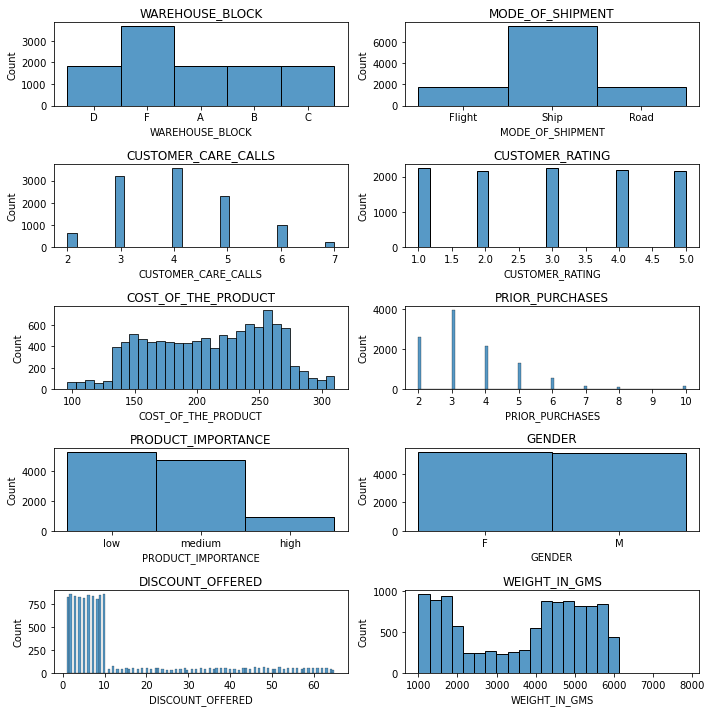

In [5]:
# Show histogram for all the predictor variables to ensure balance and evaluate behavior
fig, axs = plt.subplots(5,2, figsize = (10, 10))
fig.set_facecolor('white')
ax_list = fig.axes

for index, column in enumerate(df.columns.tolist()[:-1]):    
    sns.histplot(df, x = column, ax = ax_list[index])
    ax_list[index].set_title(column)

plt.tight_layout()

Here we can see the distributions of all the predictor variables, this is important to better understand the behavior of the variables. 

Some of the notable aspects of this plot is that the dataset is fairly balanced for most of the categorical variables, such as "Gender", "Customer_Rating" and "Warehouse_Block", however it seems to be fairly unbalanced for "Product_Importance" and "Mode_Of_Shipment". This may bias our predictions in the future and must be analyzed further.

Regarding the numerical variables, all of them display "common" distributions, such as the truncated normals seen in the "Customer_Care_calls", "Prior_Purchases" and "Weight_In_Gms" (the last one is also bimodal) and the (almost) uniform distributions seen in "Cost_Of_Product" and "Discount_Offered" (this one a composition of uniform distributions).

Considering this, I would say that there are no extreme concerns related to the quality of the data available and possible bias in the models.

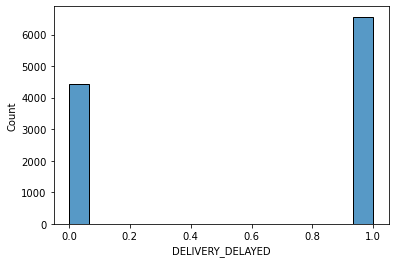

In [6]:
# Distribution of the target value
plot = sns.histplot(df, x = 'DELIVERY_DELAYED')

Finally, for the predicted variable, there is not much of a significant inbalance between the two values, which show a 60-40 split. This is once again not concerning. 

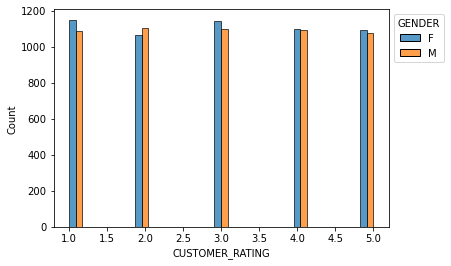

In [7]:
# Task 3 - Generate a visuals to illustrate the distributions of “Gender” x “Customer_Rating”
ax = sns.histplot(data = df, x = 'CUSTOMER_RATING', hue = 'GENDER', multiple="dodge")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [8]:
# Task 4 - Based on the data provided, does package weight seems to be related to the delivery delay?
import statsmodels.api as sm

X = df['WEIGHT_IN_GMS']
Y = df['DELIVERY_DELAYED']

model = sm.Logit(endog=Y, exog=X).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.690824
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       DELIVERY_DELAYED   No. Observations:                10999
Model:                          Logit   Df Residuals:                    10998
Method:                           MLE   Df Model:                            0
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                -0.02446
Time:                        16:43:09   Log-Likelihood:                -7598.4
converged:                       True   LL-Null:                       -7417.0
Covariance Type:            nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
WEIGHT_IN_GMS  3.427e-05    4.8e-06      7.137      0.000    2.49e-05    4.37e-05
=================================================================================
"""

To evaluate the existence of a relationship between the package weight and a delivery delay, we may build a logistic regression model as seen above. 

As shown in the summary of the model, the p-value for the weight (the only predictor for the model) is smaller than 0.000, which means that we can reject the null hypothesis, which means that there is a statistically significant relathionship between the predictor variable and the predicted variable.

<AxesSubplot:xlabel='WEIGHT_IN_GMS', ylabel='DELIVERY_DELAYED'>

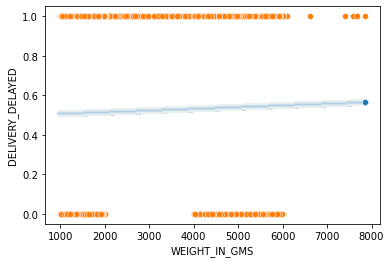

In [9]:
# Displaying logistic model results
linspace = np.linspace(np.min(df['WEIGHT_IN_GMS']), np.max(df['WEIGHT_IN_GMS']), 10000)

preds = model.predict(linspace)

sns.scatterplot(x = linspace, y = preds)
sns.scatterplot(data = df, x = 'WEIGHT_IN_GMS', y = 'DELIVERY_DELAYED')

We may further visualize this relationship with the plot shown above which displaying the instances of delays across all the package weights in the data. 

The plot also shows the predictions made by the model we built, which can be interpreted as the probability of a delay occuring or not for a given package weight.

We see that for packages above ~6000 grams, there is always a delay, and the probability of predicted by the model of a delay happening for the upper end of weights is greater than that for the lower end.

Although the model is very weak in its predictive power (which is expected with only one variable), This seems to validate the claims of a relationship made previously. However we would metrics to confirm this, instead of only using visual inspection.

In [10]:
# descriptive statistics for numerical variables
df_num = df.select_dtypes(include=np.number)
df_num.describe()

,CUSTOMER_CARE_CALLS,CUSTOMER_RATING,COST_OF_THE_PRODUCT,PRIOR_PURCHASES,DISCOUNT_OFFERED,WEIGHT_IN_GMS,DELIVERY_DELAYED
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [11]:
# descriptive statistics for categorical variables
df_cat = df.select_dtypes('object')
df_cat.describe()

,WAREHOUSE_BLOCK,MODE_OF_SHIPMENT,PRODUCT_IMPORTANCE,GENDER
count,10999,10999,10999,10999
unique,5,3,3,2
top,F,Ship,low,F
freq,3666,7462,5297,5545


In [13]:
# Preparing Dataset for predictive modeling
x = df[df.columns.tolist()[:-1]]

# One-hot encoding categorical variables
x = pd.get_dummies(x)

# Scaling of numerical variables
scaler = StandardScaler()
x = scaler.fit_transform(x)
x.shape

(10999, 19)

In [74]:
y = df[df.columns.tolist()[-1]]
y.shape

(10999,)

In [29]:
# Creating train-test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [73]:
# Defining metrics and models for selection
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

models = [GaussianNB(), SVC(gamma='auto'), LogisticRegression(), KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(), RandomForestClassifier(n_estimators = 250, max_depth=2), MLPClassifier(solver='adam', hidden_layer_sizes=(10, 10), max_iter = 500)]

results = {}

# Train and evaluate models on the train set using 5-fold cross validation. Log results
for model in models:
    tmp = cross_validate(model, x_train, y_train, cv=5, scoring = metrics)
    results[model] = tmp

#results

In [75]:
# Compute average of each of the metrics across all the 5-folds
final_stats = {}
for model in results:
    tmp = []
    for metric in results[model]:
        if 'test' in metric:
            mean = np.mean(results[model][metric])
            #print(mean)
            tmp.append(mean)
    
    final_stats[model] = tmp

#final_stats

In [76]:
# Check which model performs best on more of the metrics we have defined
model_decider = {key: 0 for key in models}

for index in range(len(metrics)):
    best_value = 0
    best_model = ''
    
    for model in final_stats:
        tmp = final_stats[model][index]
        if tmp > best_value:
            best_value = tmp
            best_model = model
    
    model_decider[best_model] += 1

model_decider

{GaussianNB(): 1,
 SVC(gamma='auto'): 1,
 LogisticRegression(): 0,
 KNeighborsClassifier(): 0,
 DecisionTreeClassifier(): 0,
 RandomForestClassifier(max_depth=2, n_estimators=250): 3,
 MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500): 0}

Here we can see that for the metrics that we have used, giving the same weight to each of the metrics, the model that perform the best on more metrics, on average across all the 5 folds, is the Random Forest Classifier. This model is the best performing on 3 of the 5 metrics used.

This is an interesting result and shows that ensemble methods can be very efficient on small datasets such as the one we have at hand. On the other hand, very complex models such as the MLP classifier tend to not perform as well because they rely on large amounts of data.

accuracy = 0.6501818181818182
precision = 0.7059161401493395
recall = 0.7319833234067897
f1 = 0.7187134502923976
roc_auc = 0.626962716792097


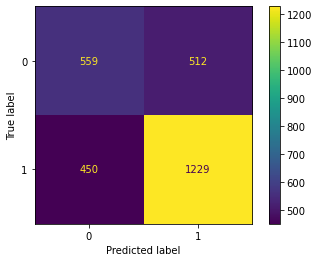

In [71]:
# Fitting model on the full training set and then doing validation on the test set
import sklearn.metrics

model = RandomForestClassifier(n_estimators = 250, max_depth=2)
model.fit(x_train, y_train)

preds = model.predict(x_test)

final_metrics = {}

final_metrics['accuracy'] = sklearn.metrics.accuracy_score(y_test, preds)
final_metrics['precision'] = sklearn.metrics.precision_score(y_test, preds)
final_metrics['recall'] = sklearn.metrics.recall_score(y_test, preds)
final_metrics['f1'] = sklearn.metrics.f1_score(y_test, preds)
final_metrics['roc_auc'] = sklearn.metrics.roc_auc_score(y_test, preds)

# Print final results
for metric in final_metrics:
    print(metric,  '=', final_metrics[metric])

cm = sklearn.metrics.confusion_matrix(y_test, preds)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(cm).plot()

Here we see that our model has more true positives and true negatives than false postives and false negatives, showing that the model indeed works and it certainly outperforms random guessing between the existence or not of a delay.